In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('\n'+'======'*8 + '%s'%nowtime)
    
printbar()


================================================2020-12-07 17:52:24


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(13)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


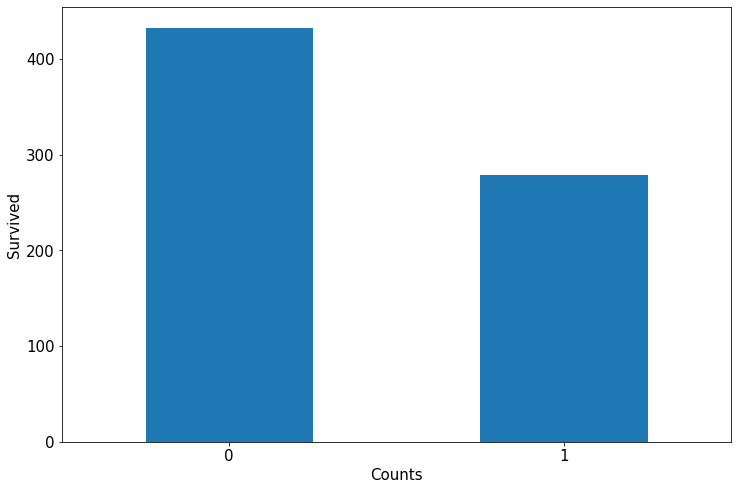

In [3]:
#利用Pandas可视化简单探索数据
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar', figsize=(12,8), fontsize=15, rot=0)
ax.set_xlabel('Counts', fontsize=15)
ax.set_ylabel('Survived', fontsize=15)
plt.show()

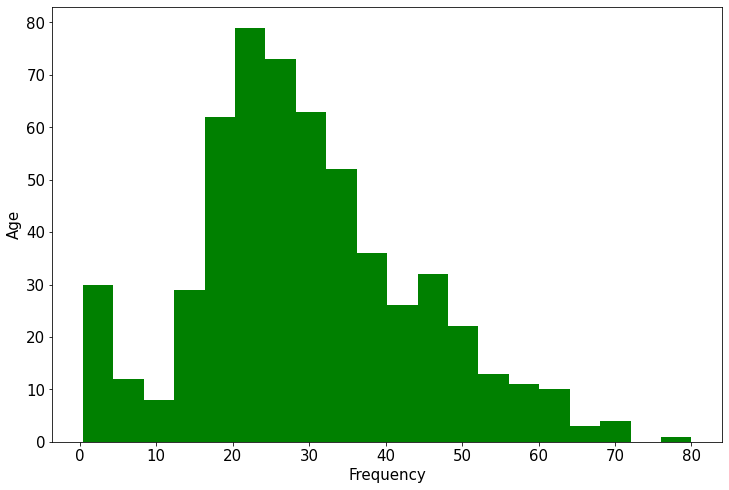

In [4]:
#年龄分布情况
ax = dftrain_raw['Age'].plot(kind='hist', bins=20, color='green', figsize=(12,8), fontsize=15)
ax.set_xlabel('Frequency', fontsize=15)
ax.set_ylabel('Age', fontsize=15)
plt.show()

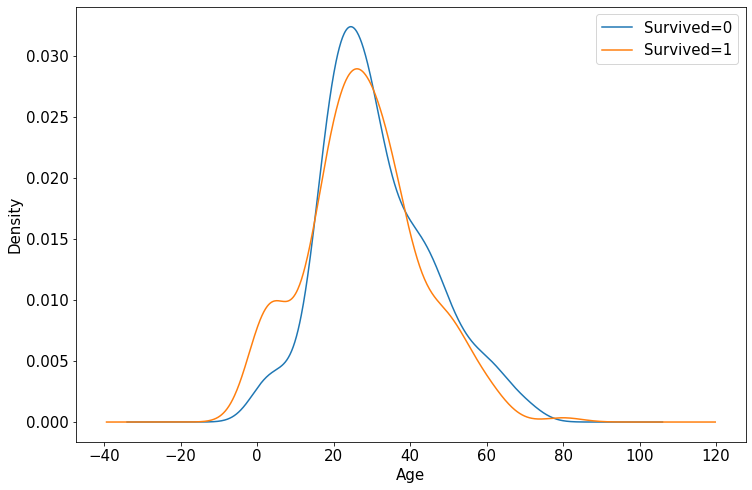

In [5]:
#利用query查看年龄与label的相关性
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind='density', figsize=(12,8), fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind='density', figsize=(12,8), fontsize=15)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
ax.legend(['Survived=0', 'Survived=1'], fontsize=15)
plt.show()

In [6]:
#数据预处理
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[['Survived']].values

x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


In [7]:
#使用DataLoader和TensorDataset封装成可以迭代的数据管道
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()),
                     shuffle=True, batch_size=8)
dl_valid = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()),
                     shuffle=False, batch_size=8)

In [8]:
#测试管道数据
for features, labels in dl_train:
    print(features, labels)
    break

tensor([[  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  44.0000,   0.0000,
           0.0000,   0.0000,   8.0500,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   1.0000,   0.0000,  19.0000,   0.0000,
           0.0000,   0.0000,   7.8792,   1.0000,   0.0000,   1.0000,   0.0000,
           0.0000],
        [  0.0000,   1.0000,   0.0000,   0.0000,   1.0000,  33.0000,   0.0000,
           0.0000,   0.0000,  12.2750,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   1.0000,
           0.0000,   0.0000,   7.7250,   1.0000,   0.0000,   1.0000,   0.0000,
           0.0000],
        [  0.0000,   1.0000,   0.0000,   0.0000,   1.0000,  34.0000,   0.0000,
           0.0000,   0.0000,  13.0000,   0.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,  27.0000,   0.0000,
           0.0000,   2.0000, 21

In [9]:
#定义模型
def create_net():
    net = nn.Sequential()
    net.add_module('linear1', nn.Linear(15,20))
    net.add_module('relu1', nn.ReLU())
    net.add_module('linear2', nn.Linear(20,15))
    net.add_module('relu2', nn.ReLU())
    net.add_module('linear3', nn.Linear(15,1))
    net.add_module('sigmoid', nn.Sigmoid())
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [10]:
from torchkeras import summary
summary(net, input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


In [12]:
#脚本形式训练循环
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = lambda y_pred, y_true: accuracy_score(y_true.data.numpy(), y_pred.data.numpy()>0.5)
metric_name = 'accuracy'
#定义损失函数，优化方法，度量方法

In [ ]:
epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ['epochs', 'loss', metric_name, 'val_loss', 'val'+metric_name])
print('Starting Training>>>')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s'%nowtime)


for i in range(1, epochs+1):
    
    #1.训练循环
    net.train()
    
